## Read Undersampled_data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from zipfile import ZipFile
from sklearn.preprocessing import MinMaxScaler

import nbimporter
import random_forest_method
import performance_measure
import svm_method_lime_compatible
import svm_method
import data_sampling
import split_data_set
import target_parser
import lime_method

Importing Jupyter notebook from random_forest_method.ipynb
Importing Jupyter notebook from performance_measure.ipynb
Importing Jupyter notebook from multiscorer.ipynb
Importing Jupyter notebook from svm_method_lime_compatible.ipynb
Importing Jupyter notebook from svm_method.ipynb
Importing Jupyter notebook from data_sampling.ipynb
Importing Jupyter notebook from split_data_set.ipynb
Importing Jupyter notebook from target_parser.ipynb
Importing Jupyter notebook from lime_method.ipynb


In [2]:
path = "../../../undersampled_data.zip"

zip_file = ZipFile(path)
undersampled_data = pd.read_csv(zip_file.open('undersampled_data.csv')) #, nrows=500000)
#data = pd.read_csv(path, compression='zip', sep=',')#, nrows=500000)

Proportion of failures in Undersampled dataset to max size 300 000:

Status			 Percentage	 Amount
Other:			 56.269%	 300000
Status_9_Substatus_8: 	 42.890 %	 228668
Status_62_Substatus_7:	 0.769%		 4098
Status_62_Substatus_30:	 0.072%		 383



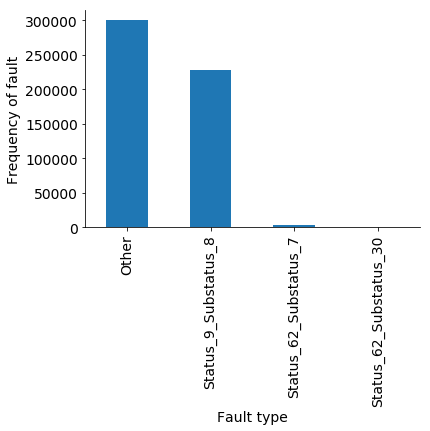

<Figure size 1440x1152 with 0 Axes>

In [3]:
data_sampling.get_statues_percentage(undersampled_data, 'Undersampled dataset to max size 300 000:\n')
data_sampling.plot_balance(undersampled_data, 'Status')

## Do more undersampling

In [4]:
undersampled_data = data_sampling.undersample_dataset(undersampled_data,20000,"Other")
undersampled_data = data_sampling.undersample_dataset(undersampled_data,20000,"Status_9_Substatus_8")

Proportion of failures in Undersampled dataset to max size 20 000:

Status			 Percentage	 Amount
Other:			 44.963%	 20000
Status_9_Substatus_8: 	 44.963 %	 20000
Status_62_Substatus_7:	 9.213%		 4098
Status_62_Substatus_30:	 0.861%		 383



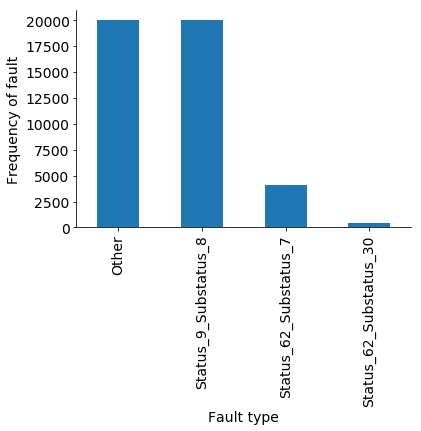

<Figure size 1440x1152 with 0 Axes>

In [5]:
data_sampling.get_statues_percentage(undersampled_data, 'Undersampled dataset to max size 20 000:\n')
data_sampling.plot_balance(undersampled_data, 'Status')

In [6]:
X = undersampled_data.drop(columns = ['Status', 'TimeStamp'])
y = np.array(undersampled_data.Status)
X.shape

(44481, 34)

In [7]:
y

array(['Status_9_Substatus_8', 'Other', 'Other', ..., 'Other',
       'Status_9_Substatus_8', 'Status_9_Substatus_8'], dtype=object)

### Translate status codes to int for easier comparison


In [8]:
y = target_parser.status_to_code(y)
y

array([1, 0, 0, ..., 0, 1, 1])

### Split into training and test

In [9]:
X_train, X_test, y_train, y_test = split_data_set.split_data(X,y)

In [10]:
np.asarray(np.unique(y_train, return_counts=True)).T

array([[    0, 13400],
       [    1, 13400],
       [    2,  2746],
       [    3,   256]])

## Random forest and feature importance


Normalized confusion matrix
[[9.83636364e-01 1.19696970e-02 4.24242424e-03 1.51515152e-04]
 [1.45454545e-02 9.85454545e-01 0.00000000e+00 0.00000000e+00]
 [7.39644970e-04 0.00000000e+00 9.99260355e-01 0.00000000e+00]
 [1.41732283e-01 1.57480315e-02 0.00000000e+00 8.42519685e-01]]


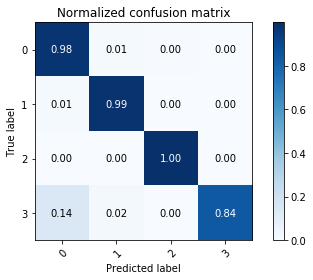

Total Accuracy 		0.985

Status 				 Precision 	 Recall 	 F1
----------------------------------------------------------------------
0                         	 0.983 		 0.984 		 0.983
1                         	 0.988 		 0.985 		 0.987
2                         	 0.980 		 0.999 		 0.989
3                         	 0.991 		 0.843 		 0.911


In [11]:
rf = random_forest_method.get_rf_model(X_train, X_test, y_train, y_test)

In [12]:
rf

,importance
ActivePower,0.157159
Log-T-Raw-TransformerTemperature,0.081052
Log-T-Raw-Rectifier1HeatSink,0.077885
Log-T-Raw-Rotor1Temperature,0.061804
Log-T-Raw-Stator2Temperature,0.046672
Log-T-Raw-Rotor2Temperature,0.045221
Average blade angle across A B C,0.043967
Log-T-Raw-Rectifier2HeatSink,0.037911
Log-T-Raw-Stator1Temperature,0.037350
Spinner-Temperature,0.034959


# Preprocessing

### Feature Extraction (based on lowest feature importance from RF)

In [13]:
dropColumns = ['Log-T-Raw-BladeATemperature', 'Log-T-Raw-BladeBTemperature', 'Log-T-Raw-BladeCTemperature',
               'Log-T-Raw-BladeAPitchControlBox', 'Log-T-Raw-BladeBPitchControlBox', 'Log-T-Raw-BladeCPitchControlBox',
               'Log-T-Raw-BladeAPitchHeatSink', 'Log-T-Raw-BladeBPitchHeatSink', 'Log-T-Raw-BladeCPitchHeatSink',
               'Log-T-Raw-RectifierCabinetTemperature', 'Log-T-Raw-NacelleControlCabinetTemperature',
               'WindVane', 'WindDirection', 'WindSpeed','Nacelle-Temperature', 'Spinner-Temperature']

def extract_features(X_train, X_test, dropColumns):
    X_train_ex = X_train.drop(columns=dropColumns)
    X_test_ex = X_test.drop(columns=dropColumns)
    return X_train_ex, X_test_ex


### MinMaxScaling

In [14]:
def do_MinMaxScaling(X_train, X_test):
    scaler  = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    # Convert to DataFrame
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = list(X_train))
    X_test_scaled_df  = pd.DataFrame(X_test_scaled, columns = list(X_train))
    
    return X_train_scaled_df, X_test_scaled_df

In [15]:
X_train_scaled, X_test_scaled = do_MinMaxScaling(X_train, X_test)

Loading...
Training...
Training Complete
Plotting Confusion Matrix...
Normalized confusion matrix
[[0.40969697 0.13666667 0.13060606 0.3230303 ]
 [0.11575758 0.64424242 0.01257576 0.22742424]
 [0.02884615 0.05473373 0.90162722 0.0147929 ]
 [0.22047244 0.06299213 0.07086614 0.64566929]]


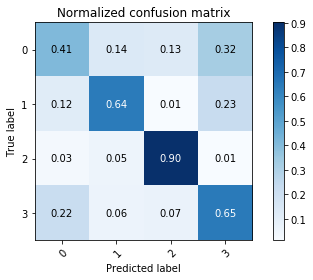

Plotting Performance Measure...
Total Accuracy 		0.563

Status 				 Precision 	 Recall 	 F1
----------------------------------------------------------------------
0                         	 0.765 		 0.410 		 0.534
1                         	 0.812 		 0.644 		 0.718
2                         	 0.561 		 0.902 		 0.692
3                         	 0.022 		 0.646 		 0.042


In [16]:
svm = svm_method_lime_compatible.get_svm_model_balanced1(X_train_scaled, X_test_scaled, y_train, y_test)

In [17]:
targetNames = svm.classes_
explainer = lime_method.run_lime(X_train_scaled, targetNames)
exp_instance = lime_method.explain_instance(X_test_scaled, svm, explainer, 2, 5)
exp_instance.show_in_notebook(show_table=True) #, show_all=True)

AttributeError: predict_proba is not available when  probability=False